# Present Wrapping Problem

The PWP can be seen as a specialization of the more general rectangle packing problem, in which we have a set of rectangles (our presents) of given dimensions that have to fit into a pre-determined square (the wrapping paper) of a given size. The great thing about PWP is that we kwow the items will perfectly fit into the given container, without any kind of wasted space.

We decided to use a list of bottom left corners (with the same index set as the list of presents shapes) as the solution representation. So, the main constraint we have dealt with are the following ones:
* Rectangles cannot overlap
* Rectangles should be completely contained inside the wrapping paper
* No wasted paper
* Rectangles cannot be rotated (unless specified)

In [178]:
%load_ext autoreload
%load_ext iminizinc
%matplotlib inline
%autoreload 2

import string
import random
from time import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from z3 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The iminizinc extension is already loaded. To reload it, use:
  %reload_ext iminizinc


## Functions

This section contains different utility functions, needed to deal with instances input/output, results handling (solutions graphical representation and running time plots), ...

In [3]:
def rand_str(size=10, chars=string.ascii_uppercase + string.digits):
    '''
    Returns a string of the given length with randomly chosen characters
    '''
    return ''.join(random.choice(chars) for _ in range(size))

In [4]:
def read_input(path):
    '''
    Read the given input instance, which should have the following format:

    W H
    N
    P1X P1Y
    ...
    PNX PNY

    Here, PIJ means present I, coordinate J, while W and H are the paper's dimensions
    '''
    file = open(path, "r").readlines()
    w_paper , h_paper = tuple(map(int, file[0].rstrip("\n").split(" ")))
    n = int(file[1].rstrip("\n"))
    presents = []
    for i in range(2, n + 2):
        presents.append(list(map(int, file[i].rstrip("\n").split(" "))))
    return w_paper, h_paper, n, presents

In [5]:
def show_solutions(w_paper, h_paper, n, presents, solutions):
    '''
    Show each and every solution as 2D plots
    '''
    assert(isinstance(solutions, list))

    colors = np.random.rand(n, 3)
    for solution in solutions:
        show_solution(w_paper, h_paper, n, presents, solution, colors)

def show_solution(w_paper, h_paper, n, presents, solution, colors=None):
    '''
    Show the given solution as a 2D plot. 
    The solution should be a list of bottom left corners, 
    contained in the given w_paper and h_paper margins
    '''
    assert(isinstance(w_paper, int))
    assert(isinstance(h_paper, int))
    assert(isinstance(presents, list))
    assert(isinstance(n, int) and n == len(presents))
    assert(isinstance(solution, list))
    assert(len(presents) == len(solution))

    if colors is None:
        colors = np.random.rand(n, 3)
    fig, ax = plt.subplots()
    for i in range(n):
        ax.add_patch(patches.Rectangle(
            solution[i],
            presents[i][0],
            presents[i][1],
            facecolor=colors[i]
        ))
    ax.set_xlim(0, w_paper)
    ax.set_ylim(0, h_paper)
    print(f"Solution: {solution}")
    plt.show()

In [181]:
def show_running_times(instances, times):
    '''
    Show instance size versus running time plot
    '''
    fig = plt.figure(figsize=(12, 8), dpi= 100, facecolor='w', edgecolor='k')
    plt.xlabel("Instance")
    plt.ylabel("Total running time")
    plt.plot(instances, times, marker='o', linestyle='dashed', linewidth=2, markersize=12)
    plt.show()

In [182]:
def order_presents(presents, method='height', reverse=False):
    '''
    Order presents, increasing or decreasing, 
    by the given method (area, height, width)
    '''
    to_sort = (
        [e[0] * e[1] for e in presents] if method == 'area'
        else [e[1] for e in presents] if method == 'height'
        else [e[0] for e in presents] if method == 'width'
        else None
    )
    sorted_indices = sorted(range(len(to_sort)), key=lambda k: to_sort[k], reverse=reverse)
    presents = [presents[i] for i in sorted_indices]
    return presents, sorted_indices

In [8]:
def output(w_paper, h_paper, n, presents, solution, model):
    '''
    Write the given solution to an output file, in a specific output folder,
    with the following format:
    
    W H
    N
    P1X P1Y  C1X C1Y
    ...
    PNX PNY  CNX CNY

    Here, PIJ means present I, coordinate J; 
    CIJ means coordinate J of the bottom left corner of present I; 
    while W and H are the paper's dimensions
    '''
    out_file = open(f"out/{model}/{w_paper}x{h_paper}-out.txt", "w+")
    print(f"{w_paper} {h_paper}", file=out_file)
    print(f"{n}", file=out_file)
    for present, position in zip(presents, solution):
        present_x, present_y = present
        position_x, position_y = position
        print(f"{present_x} {present_y}{2 * ' '}{position_x} {position_y}", file=out_file)
    out_file.close()

## CP

In this section, we reported various CP models, in which we tried different approaches, evolving from one another on the basis of references and own ideas. Some of them tend to be faster in a specific subset of instances, w.r.t. the others. In the final model, we tried to put together the different key-points of each model.

CP models are implemented with the MiniZinc language and models execution is managed by the official MiniZinc Jupyter extension, called iMiniZinc.

### Input

The following subsection is dedicated to input handling. In particular, if we want to test a single instance, we can set the `instance` variable and execute the code below to visualize one associated solution. If instead we want to test every single instance, we can just set the `instance` variable to the special value `None` and still execute the code below to both visualize every computed solution and analyze running times for every instance.

In [146]:
instance = None
min_instance, max_instance = 8, 20

Paper dimensions: 8x8
Presents dimensions: [[5, 5], [3, 5], [5, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatIntVars=22
mzn-stat: flatIntConstraints=9
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.101673
mzn-stat-end
mzn-stat: initTime=0.000674
mzn-stat: solveTime=0.000115
mzn-stat: solutions=1
mzn-stat: variables=54
mzn-stat: propagators=0
mzn-stat: propagations=9
mzn-stat: nodes=1
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=0
mzn-stat-end
Solution: [[0, 0], [5, 0], [0, 5], [5, 5]]


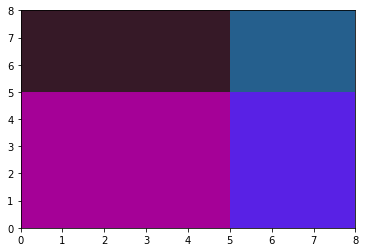


Paper dimensions: 9x9
Presents dimensions: [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=142
mzn-stat: flatIntVars=80
mzn-stat: flatBoolConstraints=67
mzn-stat: flatIntConstraints=197
mzn-stat: evaluatedReifiedConstraints=17
mzn-stat: evaluatedHalfReifiedConstraints=142
mzn-stat: eliminatedImplications=30
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.114749
mzn-stat-end
mzn-stat: initTime=0.002405
mzn-stat: solveTime=0.000256
mzn-stat: solutions=1
mzn-stat: variables=225
mzn-stat: propagators=252
mzn-stat: propagations=545
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end
Solution: [[0, 0], [3, 0], [6, 0], [6, 5], [3, 6]]


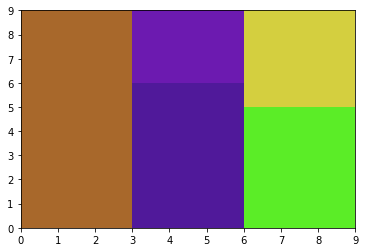


Paper dimensions: 10x10
Presents dimensions: [[4, 6], [3, 7], [3, 6], [4, 4], [3, 4], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=109
mzn-stat: flatIntVars=65
mzn-stat: flatBoolConstraints=42
mzn-stat: flatIntConstraints=149
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=103
mzn-stat: eliminatedImplications=12
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.103887
mzn-stat-end
mzn-stat: initTime=0.002107
mzn-stat: solveTime=0.000254
mzn-stat: solutions=1
mzn-stat: variables=190
mzn-stat: propagators=146
mzn-stat: propagations=361
mzn-stat: nodes=2
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=1
mzn-stat-end
Solution: [[0, 0], [4, 0], [7, 0], [0, 6], [7, 6], [4, 7]]


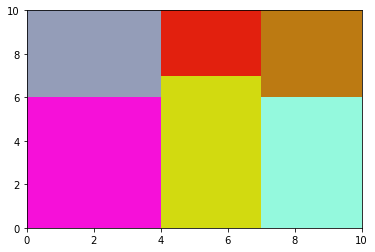


Paper dimensions: 11x11
Presents dimensions: [[8, 4], [5, 4], [3, 6], [3, 5], [5, 3], [3, 4], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=91
mzn-stat: flatIntVars=63
mzn-stat: flatBoolConstraints=21
mzn-stat: flatIntConstraints=147
mzn-stat: evaluatedReifiedConstraints=7
mzn-stat: evaluatedHalfReifiedConstraints=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.131643
mzn-stat-end
mzn-stat: initTime=0.004354
mzn-stat: solveTime=0.00097
mzn-stat: solutions=1
mzn-stat: variables=154
mzn-stat: propagators=164
mzn-stat: propagations=1067
mzn-stat: nodes=26
mzn-stat: failures=9
mzn-stat: restarts=0
mzn-stat: peakDepth=10
mzn-stat-end
Solution: [[0, 0], [0, 4], [8, 0], [8, 6], [0, 8], [5, 4], [5, 8]]


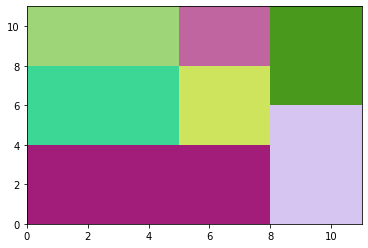


Paper dimensions: 12x12
Presents dimensions: [[3, 9], [3, 8], [3, 7], [3, 6], [6, 3], [3, 5], [3, 4], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=120
mzn-stat: flatIntVars=72
mzn-stat: flatBoolConstraints=28
mzn-stat: flatIntConstraints=183
mzn-stat: evaluatedReifiedConstraints=8
mzn-stat: evaluatedHalfReifiedConstraints=112
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.106534
mzn-stat-end
mzn-stat: initTime=0.002199
mzn-stat: solveTime=0.000465
mzn-stat: solutions=1
mzn-stat: variables=192
mzn-stat: propagators=193
mzn-stat: propagations=2125
mzn-stat: nodes=34
mzn-stat: failures=13
mzn-stat: restarts=0
mzn-stat: peakDepth=13
mzn-stat-end
Solution: [[0, 0], [6, 0], [9, 0], [3, 0], [0, 9], [9, 7], [6, 8], [3, 6]]


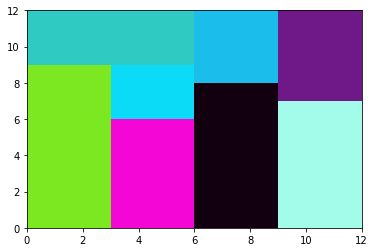


Paper dimensions: 13x13
Presents dimensions: [[7, 6], [3, 8], [3, 7], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=153
mzn-stat: flatIntVars=81
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=223
mzn-stat: evaluatedReifiedConstraints=9
mzn-stat: evaluatedHalfReifiedConstraints=144
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.106848
mzn-stat-end
mzn-stat: initTime=0.002996
mzn-stat: solveTime=0.000861
mzn-stat: solutions=1
mzn-stat: variables=234
mzn-stat: propagators=251
mzn-stat: propagations=3452
mzn-stat: nodes=102
mzn-stat: failures=46
mzn-stat: restarts=0
mzn-stat: peakDepth=13
mzn-stat-end
Solution: [[0, 0], [7, 0], [10, 0], [10, 7], [0, 6], [7, 8], [4, 6], [0, 10], [4, 10]]


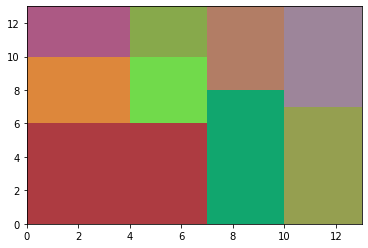


Paper dimensions: 14x14
Presents dimensions: [[5, 10], [3, 9], [3, 8], [3, 7], [5, 4], [3, 6], [3, 5], [3, 4], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=310
mzn-stat: flatIntVars=147
mzn-stat: flatBoolConstraints=140
mzn-stat: flatIntConstraints=409
mzn-stat: evaluatedReifiedConstraints=25
mzn-stat: evaluatedHalfReifiedConstraints=327
mzn-stat: eliminatedImplications=63
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.125582
mzn-stat-end
mzn-stat: initTime=0.004444
mzn-stat: solveTime=0.000353
mzn-stat: solutions=1
mzn-stat: variables=473
mzn-stat: propagators=472
mzn-stat: propagations=1203
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end
Solution: [[0, 0], [5, 0], [8, 0], [11, 0], [0, 10], [8, 8], [5, 9], [11, 7], [11, 11]]


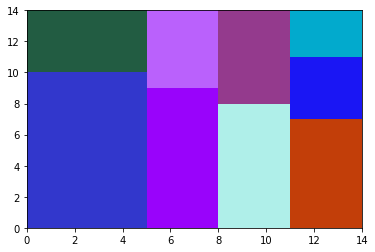


Paper dimensions: 15x15
Presents dimensions: [[3, 15], [3, 12], [3, 9], [3, 8], [3, 7], [3, 6], [6, 3], [3, 5], [3, 4], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=190
mzn-stat: flatIntVars=87
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=264
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.111658
mzn-stat-end
mzn-stat: initTime=0.00298
mzn-stat: solveTime=0.000738
mzn-stat: solutions=1
mzn-stat: variables=281
mzn-stat: propagators=275
mzn-stat: propagations=2681
mzn-stat: nodes=77
mzn-stat: failures=33
mzn-stat: restarts=0
mzn-stat: peakDepth=13
mzn-stat-end
Solution: [[0, 0], [3, 0], [6, 0], [9, 0], [12, 0], [6, 9], [9, 12], [12, 7], [9, 8], [3, 12]]


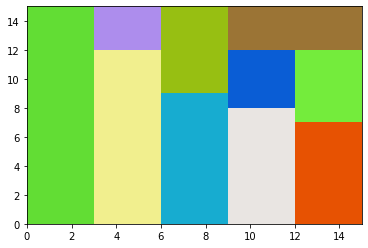


Paper dimensions: 16x16
Presents dimensions: [[7, 9], [3, 12], [3, 10], [4, 7], [3, 8], [3, 7], [3, 6], [3, 5], [3, 4], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=190
mzn-stat: flatIntVars=90
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=267
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.11365
mzn-stat-end
mzn-stat: initTime=0.002906
mzn-stat: solveTime=0.000799
mzn-stat: solutions=1
mzn-stat: variables=280
mzn-stat: propagators=284
mzn-stat: propagations=3005
mzn-stat: nodes=88
mzn-stat: failures=39
mzn-stat: restarts=0
mzn-stat: peakDepth=15
mzn-stat-end
Solution: [[0, 0], [7, 0], [10, 0], [0, 9], [13, 0], [4, 9], [10, 10], [13, 8], [7, 12], [13, 13]]


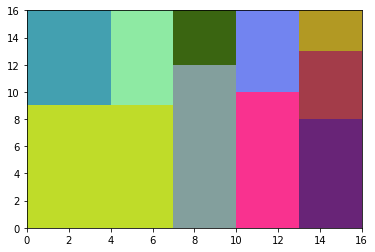


Paper dimensions: 17x17
Presents dimensions: [[4, 14], [7, 6], [4, 8], [3, 9], [3, 8], [3, 7], [7, 3], [3, 6], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=276
mzn-stat: flatIntVars=108
mzn-stat: flatBoolConstraints=66
mzn-stat: flatIntConstraints=367
mzn-stat: evaluatedReifiedConstraints=12
mzn-stat: evaluatedHalfReifiedConstraints=264
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.117652
mzn-stat-end
mzn-stat: initTime=0.00396
mzn-stat: solveTime=0.013348
mzn-stat: solutions=1
mzn-stat: variables=384
mzn-stat: propagators=417
mzn-stat: propagations=61114
mzn-stat: nodes=1370
mzn-stat: failures=678
mzn-stat: restarts=0
mzn-stat: peakDepth=26
mzn-stat-end
Solution: [[0, 0], [4, 0], [7, 6], [11, 0], [14, 0], [4, 6], [7, 14], [14, 8], [11, 9], [4, 13], [0, 14], [14, 14]]


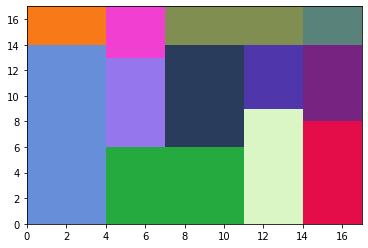


Paper dimensions: 18x18
Presents dimensions: [[3, 11], [3, 10], [5, 6], [5, 5], [3, 8], [4, 6], [3, 7], [4, 5], [5, 4], [3, 6], [4, 4], [3, 5], [5, 3], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=575
mzn-stat: flatIntVars=208
mzn-stat: flatBoolConstraints=224
mzn-stat: flatIntConstraints=705
mzn-stat: evaluatedReifiedConstraints=29
mzn-stat: evaluatedHalfReifiedConstraints=606
mzn-stat: eliminatedImplications=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.154298
mzn-stat-end
mzn-stat: initTime=0.007394
mzn-stat: solveTime=0.000605
mzn-stat: solutions=1
mzn-stat: variables=847
mzn-stat: propagators=706
mzn-stat: propagations=2679
mzn-stat: nodes=8
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=5
mzn-stat-end
Solution: [[9, 0], [12, 0], [0, 0], [0, 6], [15, 0], [5, 0], [9, 11], [5, 6], [0, 11], [15, 8], [5, 11], [12, 10], [0, 15], [15, 14], [5, 15], [12, 

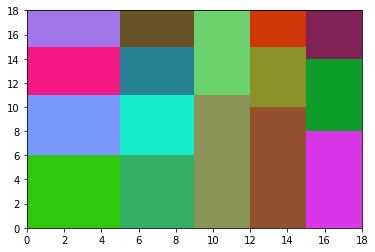


Paper dimensions: 19x19
Presents dimensions: [[3, 19], [3, 13], [3, 11], [4, 8], [3, 10], [3, 9], [3, 8], [4, 6], [3, 7], [4, 5], [3, 6], [3, 5], [3, 4], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=893
mzn-stat: flatIntVars=402
mzn-stat: flatBoolConstraints=468
mzn-stat: flatIntConstraints=1199
mzn-stat: evaluatedReifiedConstraints=61
mzn-stat: evaluatedHalfReifiedConstraints=1056
mzn-stat: eliminatedImplications=275
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.185611
mzn-stat-end
mzn-stat: initTime=0.010892
mzn-stat: solveTime=0.000816
mzn-stat: solutions=1
mzn-stat: variables=1322
mzn-stat: propagators=1502
mzn-stat: propagations=6235
mzn-stat: nodes=10
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=7
mzn-stat-end
Solution: [[4, 0], [7, 0], [10, 0], [0, 0], [13, 0], [16, 0], [10, 11], [0, 8], [16, 9], [0, 14], [7, 13], [13, 10], [13, 15], [16, 16]]


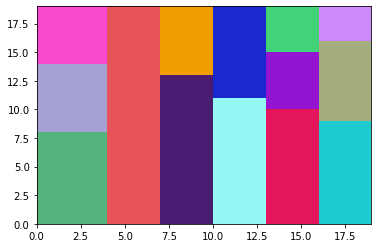


Paper dimensions: 20x20
Presents dimensions: [[4, 17], [3, 17], [4, 11], [4, 9], [3, 11], [3, 10], [3, 9], [3, 8], [3, 7], [3, 6], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=800
mzn-stat: flatIntVars=338
mzn-stat: flatBoolConstraints=379
mzn-stat: flatIntConstraints=1049
mzn-stat: evaluatedReifiedConstraints=56
mzn-stat: evaluatedHalfReifiedConstraints=888
mzn-stat: eliminatedImplications=192
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.166593
mzn-stat-end
mzn-stat: initTime=0.009893
mzn-stat: solveTime=0.000603
mzn-stat: solutions=1
mzn-stat: variables=1138
mzn-stat: propagators=1380
mzn-stat: propagations=3564
mzn-stat: nodes=5
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=4
mzn-stat-end
Solution: [[0, 0], [8, 0], [4, 0], [4, 11], [11, 0], [14, 0], [11, 11], [17, 0], [17, 8], [14, 10], [17, 15], [14, 16], [0, 17], [8, 17]]


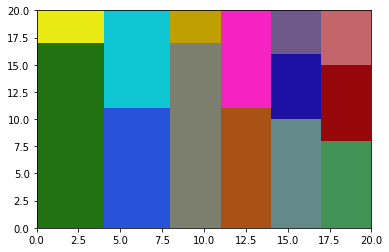


Instance size / Running time plot:


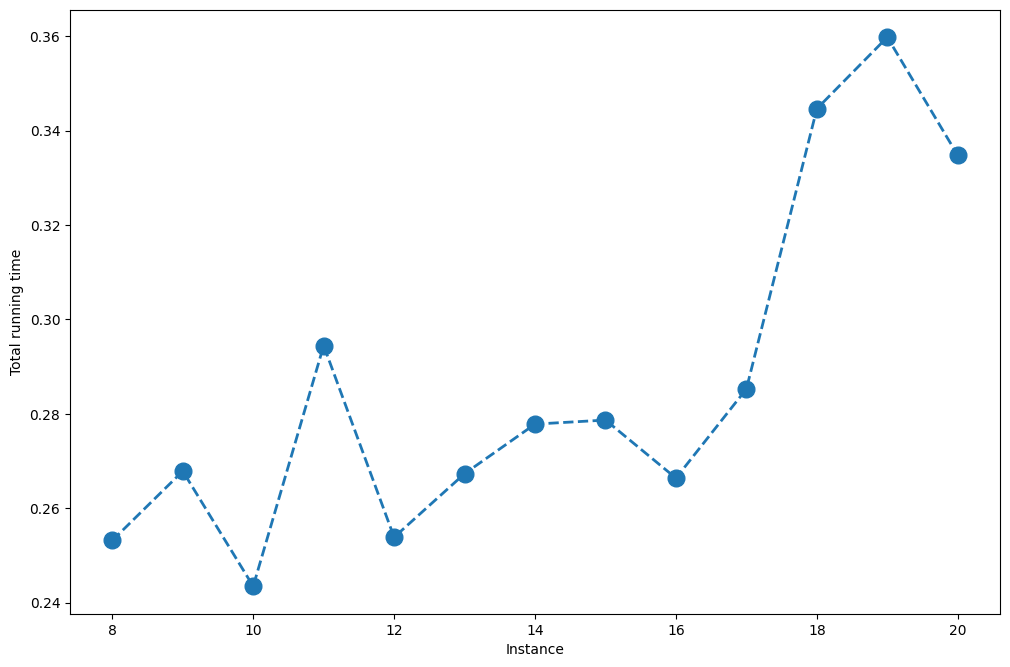

In [186]:
times = []
instances = []
if instance is not None:
    min_instance, max_instance = instance, instance
for i in range(min_instance, max_instance + 1):
    current_instance = f"{i}x{i}"
    path = f"instances/{current_instance}.txt"
    w_paper, h_paper, n, presents = read_input(path)
    unordered_presents = list(presents)
    presents, sorted_indices = order_presents(presents, method='area', reverse=True)
    bl_corners = []
    print(f"Paper dimensions: {i}x{i}")
    print(f"Presents dimensions: {presents}")
    start_time = time()
    solutions = %minizinc -s pwp-v6
    end_time = time()
    if solutions:
        solution = solutions['bl_corners'] if 'bl_corners' in solutions else solutions[0]['bl_corners']
        show_solution(w_paper, h_paper, n, presents, solution)
        output(w_paper, h_paper, n, presents, solution, model='cp')
        instances.append(i)
        times.append(end_time - start_time)
    print()

if len(instances) > 1:
    print("Instance size / Running time plot:")
    show_running_times(instances, times)

### First model 

In this first CP model we tried to put a single constraint, regarding rectangles overlapment. The constraint is implemented as a list of disjunctive comparisons and, because of that, running times of the whole model tend to be very high, starting from the smaller and easier instances.

In [88]:
%%mzn_model pwp-v1
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of int: presents;

% Variables
array[1..n, 1..2] of var 0..max(w_paper, h_paper) - 1: bl_corners;

% Constraints
% Presents cannot overlap
constraint forall(i, j in 1..n where j > i) (
    max(bl_corners[i, 1], bl_corners[j, 1]) >= min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) \/
    max(bl_corners[i, 2], bl_corners[j, 2]) >= min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2])
);

% Reduce presents domains
constraint forall(i in 1..n) (bl_corners[i, 1] <= w_paper - presents[i, 1]);
constraint forall(i in 1..n) (bl_corners[i, 2] <= h_paper - presents[i, 2]);

% Search
solve satisfy;

### Second model

In this second CP model we refactored the non-overlapping constraint by removing the disjuctive part and instead forcing all overlapping areas to be zero. Moreover, we introduced a new list of variables (`bl_corners_values`) which can be viewed as a linearization of the 2D coordinates associated with rectangles bottom left corners, since we wanted to add redundant constraints, to deal with values distribution inside the 2D space. In particular, we posed an `alldifferent` constraint over `bl_corners_values` and we forced a single rectangle to be located at `(0, 0)`.

In [93]:
%%mzn_model pwp-v2
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of int: presents;

% Constants
int: max_dim = max(w_paper, h_paper);
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);

% Variables
array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);
function var int: x_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) - max(bl_corners[i, 1], bl_corners[j, 1]));
function var int: y_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2]) - max(bl_corners[i, 2], bl_corners[j, 2]));
function var int: overlap_area(int: i, int: j) = x_overlap(i, j) * y_overlap(i, j);

% Channeling constraints
predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners[i, 1], bl_corners[i, 2]);
constraint forall(i in ns) (values_channeling(i));

% Constraints
% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint forall(i, j in 1..n where j > i) (overlap_area(i, j) == 0);

% Reduce presents domains
constraint forall(i in 1..n) (bl_corners[i, 1] <= w_paper - presents[i, 1]);
constraint forall(i in 1..n) (bl_corners[i, 2] <= h_paper - presents[i, 2]);

% Search
solve satisfy;

### Third model

In this third model we tried to further reduce our variable's domains, by introducing a new list of variables (`tr_corners`), representing top right corners of each rectangle. The main achievement of this model is the introduction of the global constraint `diffn_k` to handle non-overlapment and of the global constrainst `cumulative` to maximally stack rectangles on each axis. Moreover, we used top right corners to force rectangles to stay inside the outer container.

In [97]:
%%mzn_model pwp-v3
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of 1..max_dim: presents;

% Constants
int: max_dim = max(w_paper, h_paper);
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);
array[1..n] of 1..max_dim: presents_xs = [presents[i, 1] | i in 1..n];
array[1..n] of 1..max_dim: presents_ys = [presents[i, 2] | i in 1..n];

% Variables
array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n, 1..2] of var 1..max_dim: tr_corners;
array[1..n] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[1..n] of var 0..w_paper - min_present_dim: bl_corners_xs;
array[1..n] of var 0..h_paper - min_present_dim: bl_corners_ys;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Constraints
% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% Search
solve satisfy;

### Fourth model

In this fourth model we tried to add different constraints, to possibly enhance running times:
* Redundant constraints:
    * Try and stack two presents having the same width s.t. their heights would sum to the total height 
    * Sum of all the areas of all the placed presents equal to total area
* Symmetry breaking constraints:
    * Presents in the same column ordered by width (which resulted in an overall slowdown)
    * Biggest rectangle contained in the lower-left quadrant (which didn't lead to any major improvement)

In [127]:
%%mzn_model pwp-v4
include "globals.mzn";

%Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
int: max_dim = max(w_paper, h_paper);
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
int: max_present_ind = arg_max(areas);
set of int: ns = 1..n;
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Constraints
% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% Two presents sum to total height or width
constraint forall(i, j in ns where j > i) (
    presents_xs[i] == presents_xs[j] /\ presents_ys[i] + presents_ys[j] == h_paper -> 
    bl_corners_ys[j] = presents_ys[i] /\ bl_corners_ys[i] = 0
);
constraint forall(i, j in ns where j > i) (
    presents_ys[i] == presents_ys[j] /\ presents_xs[i] + presents_xs[j] == w_paper -> 
    bl_corners_xs[j] = presents_xs[i] /\ bl_corners_xs[i] = 0
);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Symmetry breaking constraints
% Biggest rectangle contained in the lower-left quadrant
constraint 
    bl_corners_xs[max_present_ind] <= (w_paper - presents_xs[max_present_ind]) / 2 /\ 
    bl_corners_ys[max_present_ind] <= (h_paper - presents_ys[max_present_ind]) / 2;

/*
% Presents in the same column ordered by width
constraint forall(i, j in ns where j > i) (
    bl_corners_xs[i] == bl_corners_xs[j] /\ presents_xs[i] <= presents_xs[j] -> 
    bl_corners_ys[i] > bl_corners_ys[j]
);
*/

% Search
solve satisfy;

### Fifth model

In this fifth model we are generalizing the idea of stacking two rectangles of the same width with heights summing to the total height, to:
* Partition rectangles in groups representing different widths (`presents_group_xs`)
* Check whether all groups form one or more columns (predicate `is_col_stacking_feasible`)
    * If possible, assign each rectangle to a specific column and constrain the other rectangles to follow (predicate `stack_cols`)
    * If not possible, operate in previous models

The predicate `stack_cols` works as follows:
* For each rectangle group
    * Find a feasible `bin_packing` over a pre-computed number of columns
    * For each rectangle in the same column (same bin), add a constraint to fix its bottom left corner

We also tried to combine our ad-hoc column stacking procedure with the approaches described below (_intervals_ and _anchor points_), without any luck.

In [98]:
%%mzn_model pwp-v5
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
bool: col_stacking_feasible = is_col_stacking_feasible();
int: max_dim = max(w_paper, h_paper);
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
int: max_present_ind = arg_max(areas);
set of int: ns = 1..n;
set of int: presents_xs_values = distinct_values(presents_xs);
array[int] of int: presents_xs_ordered_values = sort_by(presents_xs_values, [-i | i in presents_xs_values]);
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[1..card(presents_xs_values)] of set of ns: presents_group_xs = [group_presents(i, 1) | i in presents_xs_ordered_values];
array[1..card(presents_xs_values)] of int: group_columns = 
    [sum([presents_ys[j] | j in presents_group_xs[i]]) div h_paper | i in 1..card(presents_xs_values)];
array[1..card(presents_xs_values)] of int: group_widths = 
    [sum([presents_xs[j] | j in presents_group_xs[i]]) div card(presents_group_xs[i]) | i in 1..card(presents_xs_values)];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;

% Functions
function bool: is_col_stacking_feasible() = 
    sum([sum([presents_ys[j] | j in presents_group_xs[i]]) >= h_paper | i in 1..card(presents_xs_values)]) == card(presents_xs_values);
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };
function set of ns: group_presents(int: size, int: axis) = {i | i in ns where presents[i, axis] == size};
function int: get_starting_point(int: i) = sum([group_columns[j] * group_widths[j] | j in 1..i - 1]);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Constraints
% Stack presents with the same width on the same column
predicate stack_cols(int: i, int: starting_point) = let { 
    int: n_presents = card(presents_group_xs[i]);
    array[1..n_presents] of ns: indexes = [j | j in presents_group_xs[i]];
    array[1..n_presents] of 1..h_paper: weights = [presents_ys[j] | j in indexes];
    int: columns = group_columns[i];
    array[1..n_presents] of var 1..columns: bins
    } in 
        bin_packing(h_paper, bins, weights) /\
        forall(h in 1..n_presents, l in 1..columns where bins[h] == l) (
            bl_corners_xs[indexes[h]] == starting_point + (group_widths[i] * (l - 1)) /\
            bl_corners_ys[indexes[h]] == sum([weights[j] | j in 1..h - 1 where bins[j] == l]) 
        );
constraint
    trace("Column stacking: " ++ show(col_stacking_feasible) ++ "\n", col_stacking_feasible) -> 
    forall(i in 1..card(presents_xs_values)) (stack_cols(i, get_starting_point(i)));

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint not(col_stacking_feasible) -> cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Symmetry breaking constraints
% Biggest rectangle contained in the lower-left quadrant
constraint not(col_stacking_feasible) ->
    bl_corners_xs[max_present_ind] <= (w_paper - presents_xs[max_present_ind]) / 2 /\ 
    bl_corners_ys[max_present_ind] <= (h_paper - presents_ys[max_present_ind]) / 2;

% Search
solve satisfy;

#### Intervals approach

The following section contains a block of code that was tested in the above model, but didn't provide significant improvements. It represents an idea taken from the paper _New Improvements in Optimal Rectangle Packing (Eric Huang, Richard E. Korf)_, where domains associated with the x-coordinate of bottom left corners are reduced on the basis of a variable-sized interval:
> \[...\] a rectangle is assigned an interval of x-coordinates. Interval sizes are hand-picked for each rectangle prior to search, and they induce a smaller rectangle representing the common intersecting area of placing the rectangle in any location in the interval. \[...\] we assign all x-coordinates prior to any y-coordinates, and use interval variables for the x-coordinates. We set a rectangle’s interval size to 0.35 times its width, which gave us the best performance. Finally, we do not use interval variables for the y-coordinates.`

In [ ]:
% Constants
array[ns] of int: x_intervals_sizes = [ceil(presents_xs[i] * 0.35) | i in ns];

% Variables
array[ns, 1..2] of var 0..w_paper: x_intervals;

% Channeling constraints
predicate x_intervals_channeling(int: i) = 
    x_intervals[i, 2] == x_intervals[i, 1] + x_intervals_sizes[i] /\
    bl_corners_xs[i] >= x_intervals[i, 1] /\
    bl_corners_xs[i] <= x_intervals[i, 2];
constraint forall(i in ns) (x_intervals_channeling(i));

% Constraints
% Reduce corners domains based on x intervals
constraint forall(i, j in ns where j != i) (
    not(
        bl_corners_xs[j] < x_intervals[i, 2] + presents_xs[i] - x_intervals_sizes[i] /\ 
        bl_corners_xs[j] > x_intervals[i, 2] /\
        bl_corners_ys[j] >= bl_corners_ys[i] /\
        bl_corners_ys[j] < bl_corners_ys[i] + presents_ys[i]     
    )
);

% Search
solve :: seq_search([
    int_search(x_intervals, smallest, indomain_min),
    int_search(bl_corners_xs, smallest, indomain_min),
    int_search(bl_corners_ys, smallest, indomain_min)
]) satisfy;

#### Anchor points approach

The following section contains a block of code that was tested in the above model, but didn't provide significant improvements. It represents a reduction on each present's domain, s.t. bottom left corners reside on corners of other rectangles or on the wrapping paper borders.

The main problem of this implementation was our inability of correctly expressing the constraint in an efficient way.

In [ ]:
% Variables
array[ns, 1..4] of var 0..coord_to_value(w_paper, h_paper): corners_values;

% Channeling constraints
predicate corners_values_channeling(int: i) = 
    corners_values[i, 1] == bl_corners_values[i] /\ 
    corners_values[i, 2] == coord_to_value(bl_corners_xs[i] + presents_xs[i], bl_corners_ys[i]) /\
    corners_values[i, 3] == coord_to_value(tr_corners[i, 1], tr_corners[i, 2]) /\
    corners_values[i, 4] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i] + presents_ys[i]);
constraint forall(i in ns) (corners_values_channeling(i));

% Constraints
% Corners anchor points
predicate anchor_points() = let {
        array[1..n * 4] of var int: lin_corners_values = array1d(1..n * 4, corners_values)
    } in
    nvalue(lin_corners_values) <= 2 * n + 2 /\ 
    count_eq(lin_corners_values, coord_to_value(0, 0), 1) /\
    count_eq(lin_corners_values, coord_to_value(0, w_paper), 1) /\
    count_eq(lin_corners_values, coord_to_value(h_paper, 0), 1) /\
    count_eq(lin_corners_values, coord_to_value(w_paper, h_paper), 1);
constraint anchor_points();

### Sixth model

In this sixth final model we are keeping the column stacking mechanism and introducing a new variables ordering (by decreasing rectangles areas) for symmetry breaking constraints and for a new search strategy. 

These adaptations were taken from _Implementation and Evaluation of a Sweep-Based Propagator for Diffn in Gecode (Mikael Östlund)_.

Moreover, we tried to implement another anchor points approach, which didn't work out as expected.

In [185]:
%%mzn_model pwp-v6
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
bool: col_stacking_feasible = is_col_stacking_feasible();
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: max_dim = max(w_paper, h_paper);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
set of int: ns = 1..n;
set of int: presents_xs_values = distinct_values(presents_xs);
array[int] of int: presents_xs_ordered_values = sort_by(presents_xs_values, [-i | i in presents_xs_values]);
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[1..card(presents_xs_values)] of set of ns: presents_group_xs = [group_presents(i, 1) | i in presents_xs_ordered_values];
array[1..card(presents_xs_values)] of int: group_columns = 
    [sum([presents_ys[j] | j in presents_group_xs[i]]) div h_paper | i in 1..card(presents_xs_values)];
array[1..card(presents_xs_values)] of int: group_widths = 
    [sum([presents_xs[j] | j in presents_group_xs[i]]) div card(presents_group_xs[i]) | i in 1..card(presents_xs_values)];
array[int] of int: order = sort_by(ns, [-areas[i] | i in ns]);

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;

% Functions
function bool: is_col_stacking_feasible() = 
    sum([sum([presents_ys[j] | j in presents_group_xs[i]]) >= h_paper | i in 1..card(presents_xs_values)]) == card(presents_xs_values);
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };
function set of ns: group_presents(int: size, int: axis) = {i | i in ns where presents[i, axis] == size};
function int: get_starting_point(int: i) = sum([group_columns[j] * group_widths[j] | j in 1..i - 1]);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

% Constraints
% Stack presents with the same width on the same column
predicate stack_cols(int: i, int: starting_point) = let { 
    int: n_presents = card(presents_group_xs[i]);
    array[1..n_presents] of ns: indexes = [j | j in presents_group_xs[i]];
    array[1..n_presents] of 1..h_paper: weights = [presents_ys[j] | j in indexes];
    int: columns = group_columns[i];
    array[1..n_presents] of var 1..columns: bins
    } in 
        bin_packing(h_paper, bins, weights) /\
        forall(h in 1..n_presents, l in 1..columns where bins[h] == l) (
            bl_corners_xs[indexes[h]] == starting_point + (group_widths[i] * (l - 1)) /\
            bl_corners_ys[indexes[h]] == sum([weights[j] | j in 1..h - 1 where bins[j] == l]) 
        );
constraint
    trace("Column stacking: " ++ show(col_stacking_feasible) ++ "\n", col_stacking_feasible) -> 
    forall(i in 1..card(presents_xs_values)) (stack_cols(i, get_starting_point(i)));

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint not(col_stacking_feasible) -> cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% Non-optimal constraints
% Anchor points
/*
constraint forall(i in ns)(
    member([0] ++ [bl_corners_xs[j] + presents_xs[j] | j in ns where j != i], bl_corners_xs[i]) /\
    member([0] ++ [bl_corners_ys[j] + presents_ys[j] | j in ns where j != i], bl_corners_ys[i])
);
*/

% Symmetry breaking constraints
% The biggest rectangle should be placed below the second biggest
constraint let {
    int: i = order[1], int: j = order[2]
} in not(col_stacking_feasible) ->
    lex_less([bl_corners_ys[i], bl_corners_xs[i]], [bl_corners_ys[j], bl_corners_xs[j]]);

% Search
solve::
    if not(col_stacking_feasible) then
        seq_search([
            int_search([bl_corners_ys[i] | i in order], input_order, indomain_min, complete),
            int_search([bl_corners_xs[i] | i in order], input_order, indomain_min, complete)
        ])
    else int_search(bl_corners_values, dom_w_deg, indomain_min, complete)
    endif
satisfy;

### Seventh model (with rotation and same dimensions handling)

In [ ]:
%%mzn_model pwp-v7
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
bool: col_stacking_feasible = is_col_stacking_feasible();
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: max_dim = max(w_paper, h_paper);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
set of int: ns = 1..n;
set of int: presents_xs_values = distinct_values(presents_xs);
array[int] of int: presents_xs_ordered_values = sort_by(presents_xs_values, [-i | i in presents_xs_values]);
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[1..card(presents_xs_values)] of set of ns: presents_group_xs = [group_presents(i, 1) | i in presents_xs_ordered_values];
array[1..card(presents_xs_values)] of int: group_columns = 
    [sum([presents_ys[j] | j in presents_group_xs[i]]) div h_paper | i in 1..card(presents_xs_values)];
array[1..card(presents_xs_values)] of int: group_widths = 
    [sum([presents_xs[j] | j in presents_group_xs[i]]) div card(presents_group_xs[i]) | i in 1..card(presents_xs_values)];
array[int] of int: order = sort_by(ns, [-areas[i] | i in ns]);

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;

% Functions
function bool: is_col_stacking_feasible() = 
    sum([sum([presents_ys[j] | j in presents_group_xs[i]]) >= h_paper | i in 1..card(presents_xs_values)]) == card(presents_xs_values);
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };
function set of ns: group_presents(int: size, int: axis) = {i | i in ns where presents[i, axis] == size};
function int: get_starting_point(int: i) = sum([group_columns[j] * group_widths[j] | j in 1..i - 1]);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

% Constraints
% Stack presents with the same width on the same column
predicate stack_cols(int: i, int: starting_point) = let { 
    int: n_presents = card(presents_group_xs[i]);
    array[1..n_presents] of ns: indexes = [j | j in presents_group_xs[i]];
    array[1..n_presents] of 1..h_paper: weights = [presents_ys[j] | j in indexes];
    int: columns = group_columns[i];
    array[1..n_presents] of var 1..columns: bins
    } in 
        bin_packing(h_paper, bins, weights) /\
        forall(h in 1..n_presents, l in 1..columns where bins[h] == l) (
            bl_corners_xs[indexes[h]] == starting_point + (group_widths[i] * (l - 1)) /\
            bl_corners_ys[indexes[h]] == sum([weights[j] | j in 1..h - 1 where bins[j] == l]) 
        );
constraint
    trace("\nColumn stacking: " ++ show(col_stacking_feasible) ++ "\n", col_stacking_feasible) -> 
    forall(i in 1..card(presents_xs_values)) (stack_cols(i, get_starting_point(i)));

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint not(col_stacking_feasible) -> cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Anchor points
constraint forall(i in ns)(
    member([0] ++ [bl_corners_xs[j] + presents_xs[j] | j in ns where j != i], bl_corners_xs[i]) /\
    member([0] ++ [bl_corners_ys[j] + presents_ys[j] | j in ns where j != i], bl_corners_ys[i])
);

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% Symmetry breaking constraints
% The biggest rectangle should be placed below the second biggest
constraint let {
    int: i = order[1], int: j = order[2]
} in not(col_stacking_feasible) ->
    lex_less([bl_corners_ys[i], bl_corners_xs[i]], [bl_corners_ys[j], bl_corners_xs[j]]);

% Rectangles with same dimensions handling
constraint forall(i in ns)(
    let {
        array[int] of int: same_dim_ind = [j | j in ns where presents_xs[j] = presents_xs[i] /\ presents_ys[j] = presents_ys[i]]
    } in 
        if length(same_dim_ind) > 1 /\ min(same_dim_ind) = i then
            forall(j in index_set(same_dim_ind) where j > 1) (
                lex_less(
                    [bl_corners_ys[same_dim_ind[j - 1]], bl_corners_xs[same_dim_ind[j - 1]]], 
                    [bl_corners_ys[same_dim_ind[j]], bl_corners_xs[same_dim_ind[j]]]
                )
            )
        else true 
        endif
);

% Search
solve::
    if not(col_stacking_feasible) then
        seq_search([
            int_search([bl_corners_ys[i] | i in order], input_order, indomain_min, complete),
            int_search([bl_corners_xs[i] | i in order], input_order, indomain_min, complete)
        ])
    else int_search(bl_corners_values, dom_w_deg, indomain_min, complete)
    endif
satisfy;

## SMT

### Functions

In [187]:
def member(x, l):
    '''
    Return a contraint computing membership testing
    '''
    return Or([x == l[i] for i in range(len(l))])

def z3_max_list(l):
    '''
    Return a constraint computing the maximum over a list of variables
    '''
    c = []
    max_value = Int(rand_str())
    c.append(member(max_value, l))
    for i in range(len(l)):
        c.append(max_value >= l[i])
    return max_value, c

def z3_max(x, y):
    '''
    Return a constraint computing the maximum of two variables
    '''
    return If(x > y, x, y)

def z3_min_list(l):
    '''
    Return a constraint computing the minimum over a list of variables
    '''
    c = []
    min_value = Int(rand_str())
    c.append(member(min_value, l))
    for i in range(len(l)):
        c.append(min_value <= l[i])
    return min_value, c

def z3_min(x, y):
    '''
    Return a constraint computing the minimum of two variables
    '''
    return If(x < y, x, y)

def z3_bool2int(v):
    '''
    Convert a boolean variable to an integer one
    '''
    return IntSort().cast(v)

def z3_diffn(x, y, dx, dy):
    '''
    Return a list of constraints computing non-overlapping checks
    '''
    c = []
    n = len(x)
    for i in range(n):
        for j in range(i + 1, n):
            c.append(
                And(Or([
                    x[i] + dx[i] <= x[j],
                    y[i] + dy[i] <= y[j],
                    x[j] + dx[j] <= x[i],
                    y[j] + dy[j] <= y[i]
                ]))
            )
    return c

def z3_cumulative(s, d, r, b, ls, us):
    '''
    Return a list of constraints computing cumulative checks.
    Here, resources `r`, durations `d` and bound `b` must be fixed
    '''
    c = []
    early = ls
    late = us + max(d)
    tasks = [i for i in range(len(s)) if r[i] > 0 and d[i] > 0]
    if late - early < 5000:
        for i in tasks:
            c1 = []
            for j in tasks:
                if j != i:
                    c1.append(z3_bool2int(And(s[j] <= s[i], s[i] < s[j] + d[j])) * r[j])
            c.append(b >= r[i] + Sum(c1))
    else:
        for t in range(early, late + 1):
            for i in tasks:
                c.append(
                    Sum([(If(s[i] <= t, 1, 0) * If(t < s[i] + d[i], 1, 0)) * r[i] for i in tasks]) <= b
                )
    return c

### Input

In [207]:
instance = 29
min_instance, max_instance = 8, 40

In [208]:
times = []
instances = []
if instance is not None:
    min_instance, max_instance = instance, instance
for i in range(min_instance, max_instance + 1):
    current_instance = f"{i}x{i}"
    instances.append(current_instance)
    path = f"instances/{current_instance}.txt"
    w_paper, h_paper, n, presents = read_input(path)
    print(f"Paper dimensions: {i}x{i}")
    print(f"Presents dimensions: {presents}")
    start_time = time()
    bl_corners, model = smt_v1(w_paper, h_paper, n, presents)
    model.check()
    assignment = model.model()
    solution = [[assignment[bl_corners[i][0]].as_long(), assignment[bl_corners[i][1]].as_long()] for i in range(n)]
    end_time = time()
    total_time = end_time - start_time
    times.append(total_time)
    print(model.statistics())
    print(f"Total running time: {round(total_time, 3)} seconds")
    if solution:
        show_solution(w_paper, h_paper, n, presents, solution)
        output(w_paper, h_paper, n, presents, solution, model='smt')
print("Instance size / Running time plot:")
show_running_times(instances, times)

Paper dimensions: 29x29
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]


Z3Exception: model is not available

### First model

In [192]:
def smt_v1(w_paper, h_paper, n, presents):
    presents_xs = [presents[i][0] for i in range(n)]
    presents_ys = [presents[i][1] for i in range(n)]
    bl_corners = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n) ]
    bl_corners_xs = [bl_corners[i][0] for i in range(n)]
    bl_corners_ys = [bl_corners[i][1] for i in range(n)]
    domain = [
        And(
            0 <= bl_corners[i][0], bl_corners[i][0] <= w_paper - presents[i][0], 
            0 <= bl_corners[i][1], bl_corners[i][1] <= h_paper - presents[i][1]
        ) for i in range(n)
    ]
    no_overlap = z3_diffn(bl_corners_xs, bl_corners_ys, presents_xs, presents_ys)
    x_bound = z3_cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper, 0, w_paper - 1);
    y_bound = z3_cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper, 0, h_paper - 1);

    model = Solver()
    model.add(domain + no_overlap + x_bound + y_bound)
    return bl_corners, model